In [1]:
import os
import env
import random
import threading
import numpy as np
import multiprocessing
import tensorflow as tf
import matplotlib.pyplot as plt

C:\Users\ERIC-PC2\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
MAX_GLOBAL_EPISODE = 5000
GLOBAL_RUNNING_REWARD = []
GLOBAL_RUNNING_STEPS = []
GLOBAL_EPISODE = 0
GLOBAL_SUCCESS_EPISODE = 0

In [3]:
class AC_Network:
    
    def __init__(self, name, observation_space, action_space, globalAC=None, actor_H_size = 600, critic_H_size = 400, 
                 entropy_beta = 0.01, actor_lr = 0.0001, critic_lr = 0.001, load_path = None):

        # Environment
        self.state_n = observation_space
        self.action_n = action_space
        self.name = name
        
        # Learning Settings
        self.entropy_beta = entropy_beta
        self.actor_learning_rate = actor_lr
        self.critic_learning_rate = critic_lr
        
        # NN Settings
        self.actor_hidden_size = actor_H_size
        self.critic_hidden_size = critic_H_size
        
        # Init AC Network
        if(globalAC == None):
            
            # Global Network
            with tf.variable_scope(name):
                self.state = tf.placeholder(shape = [None, self.state_n], dtype = tf.float32, name = "state")
                mu, sigma, _, self.actor_params, self.critic_params = self._build_net()
                
                # Global predict (No train)
                sigma += 1e-4
                normal_dist = tf.distributions.Normal(mu, sigma)
                self.predict = tf.clip_by_value(tf.squeeze(normal_dist.sample(1), axis=[0, 1]), -1, 1)

        else: 
            
            # Local Network
            with tf.variable_scope(name):
                self.state = tf.placeholder(shape = [None, self.state_n], dtype = tf.float32, name = "state")
                self.action = tf.placeholder(shape = [None, self.action_n], dtype = tf.float32, name = "action")
                self.target_value = tf.placeholder(shape = [None, 1], dtype = tf.float32, name = "target_value")
                mu, sigma, self.v, self.actor_params, self.critic_params = self._build_net()

                # TD error and critic network loss function
                TD_error = tf.subtract(self.target_value, self.v, name = "TD_error")
                self.critic_loss = tf.reduce_mean(tf.square(TD_error))

                # Actor network loss function add entropy to encourage exploration
                sigma += 1e-4
                normal_dist = tf.distributions.Normal(mu, sigma)
                log_prob = normal_dist.log_prob(self.action)
                exploration_v = log_prob * tf.stop_gradient(TD_error)
                entropy = normal_dist.entropy()
                self.exploration_v = self.entropy_beta * entropy + exploration_v
                self.actor_loss = tf.reduce_mean(-self.exploration_v)

                # Use Loacal network to choose action
                self.predict = tf.clip_by_value(tf.squeeze(normal_dist.sample(1), axis=[0, 1]), -1, 1)
                
                # Calculate local gradient
                self.actor_grads = tf.gradients(self.actor_loss, self.actor_params)
                self.critic_grads = tf.gradients(self.critic_loss, self.critic_params)


            # Pull parameters from global network
            self.pull_actor_params = [local_params.assign(global_params) for local_params, global_params in zip(self.actor_params, globalAC.actor_params)]
            self.pull_critic_params = [local_params.assign(global_params) for local_params, global_params in zip(self.critic_params, globalAC.critic_params)]
            
            # Push parameters to global network
            self.actor_optimizer = tf.train.RMSPropOptimizer(self.actor_learning_rate, name = "RMSPropA")
            self.critic_optimizer = tf.train.RMSPropOptimizer(self.critic_learning_rate, name = "RMSPropA")
            self.push_actor_params = self.actor_optimizer.apply_gradients(zip(self.actor_grads, globalAC.actor_params))
            self.push_critic_params = self.critic_optimizer.apply_gradients(zip(self.critic_grads, globalAC.critic_params))
        
        # Load Network
        self.saver = tf.train.Saver()
        if(load_path is not None):
            self.saver.restore(SESS, load_path)

    def _build_net(self):
        
        # Init weight
        weight_init = tf.random_normal_initializer(-0.1, 0.1)
        
        # Actor Network
        with tf.variable_scope("actor"):
            actor_H1 = tf.layers.dense(self.state, self.actor_hidden_size, tf.nn.relu6, kernel_initializer = weight_init, name = "actor_hidden_layer1")
            actor_H2 = tf.layers.dense(actor_H1, self.actor_hidden_size, tf.nn.relu6, kernel_initializer = weight_init, name = "actor_hidden_layer2")
            mu = tf.layers.dense(actor_H2, self.action_n, tf.nn.tanh, kernel_initializer = weight_init, name = "mu")
            sigma = tf.layers.dense(actor_H2, self.action_n, tf.nn.softplus, kernel_initializer = weight_init, name = "sigma")
        
        # Critic Network
        with tf.variable_scope("critic"):
            critic_H1 = tf.layers.dense(self.state, self.critic_hidden_size, tf.nn.relu6, kernel_initializer = weight_init, name = "critic_hidden_layer1")
            critic_H2 = tf.layers.dense(critic_H1, self.critic_hidden_size, tf.nn.relu6, kernel_initializer = weight_init, name = "critic_hidden_layer2")
            v = tf.layers.dense(critic_H2, 1, kernel_initializer = weight_init, name = 'v') 
        
        # Trainable parameters 
        actor_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = self.name + "/actor")
        critic_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = self.name + "/critic")
        return mu, sigma, v, actor_params, critic_params

    def update_global(self, feed_dict):
        SESS.run([self.push_actor_params, self.push_critic_params], feed_dict)

    def pull_global(self):
        SESS.run([self.pull_actor_params, self.pull_critic_params])

    def choose_action(self, state):
        return SESS.run(self.predict, {self.state: state[np.newaxis, :]})

    # Model saver
    def save_Network(self, path = "./Network_save/A3C"):
        self.saver.save(SESS, path)

In [4]:
class Worker(object):
    def __init__(self, name, globalAC, max_steps = 1000, train_freq = 10, gamma = 0.8):
        
        # Environment
        self.env = env.ArmEnv()
        self.observation_space = self.env.state_dim
        self.action_space = self.env.action_dim
        
        # Global Network
        self.globalAC = globalAC
        
        # Learning Settings
        self.max_steps = max_steps
        self.train_freq = train_freq
        self.gamma = gamma
        
        # Local Network
        self.name = name
        self.AC = AC_Network(self.name, self.observation_space, self.action_space, globalAC = self.globalAC)

    def work(self):
        
        # Global parameters
        global GLOBAL_RUNNING_REWARD, GLOBAL_EPISODE, GLOBAL_RUNNING_STEPS, GLOBAL_SUCCESS_EPISODE
        
        # Store trajectory
        total_step = 1
        state_buffer = []
        action_buffer = []
        reward_buffer = []
        
        # Run episode
        while(not COORD.should_stop() and GLOBAL_SUCCESS_EPISODE < MAX_GLOBAL_EPISODE):
            state = self.env.reset()
            episode_reward = 0
            for step in range(self.max_steps):
                
                # Choose action
                action = self.AC.choose_action(state)
                
                # Take action and observe
                next_state, reward, done = self.env.step(action)
                episode_reward += reward
                state_buffer.append(state)
                action_buffer.append(action)
                reward_buffer.append(reward)

                # Train netwrok
                if(total_step % self.train_freq == 0 or done or step == self.max_steps - 1):
                    if done:
                        next_state_value = 0 
                    else:
                        next_state_value = SESS.run(self.AC.v, {self.AC.state: next_state[np.newaxis, :]})[0, 0]
                    
                    targetV_buffer = []
                    for reward in reward_buffer[::-1]:
                        next_state_value = reward + self.gamma * next_state_value
                        targetV_buffer.append(next_state_value)
                    targetV_buffer.reverse()

                    state_buffer = np.vstack(state_buffer)
                    action_buffer = np.vstack(action_buffer)
                    targetV_buffer = np.vstack(targetV_buffer)
                
                    self.AC.update_global(feed_dict = {self.AC.state: state_buffer, self.AC.action: action_buffer, self.AC.target_value: targetV_buffer})
                    state_buffer = []
                    action_buffer = []
                    reward_buffer = []
                    self.AC.pull_global()

                state = next_state
                total_step += 1
                if(done or step == self.max_steps - 1):
                    if(len(GLOBAL_RUNNING_REWARD) == 0):
                        GLOBAL_RUNNING_REWARD.append(episode_reward)
                    else:
                        GLOBAL_RUNNING_REWARD.append(0.9 * GLOBAL_RUNNING_REWARD[-1] + 0.1 * episode_reward)
                    GLOBAL_RUNNING_STEPS.append(step + 1)
                    if(done):
                        GLOBAL_SUCCESS_EPISODE += 1
                    print(self.name, "Episode:", GLOBAL_EPISODE, "| Steps: %i| Success_steps: %i" % (GLOBAL_RUNNING_STEPS[-1], GLOBAL_SUCCESS_EPISODE))
                    GLOBAL_EPISODE += 1
                    break


Worker_6 Episode: 0 | Steps: 1000| Success_steps: 0
Worker_5 Episode: 1 | Steps: 1000| Success_steps: 0
Worker_1 Episode: 2 | Steps: 1000| Success_steps: 0
Worker_3 Episode: 3 | Steps: 1000| Success_steps: 0
Worker_0 Episode: 4 | Steps: 1000| Success_steps: 0
Worker_2 Episode: 5 | Steps: 1000| Success_steps: 0
Worker_7 Episode: 6 | Steps: 1000| Success_steps: 0
Worker_4 Episode: 7 | Steps: 1000| Success_steps: 0
Worker_5 Episode: 8 | Steps: 1000| Success_steps: 0
Worker_6 Episode: 9 | Steps: 1000| Success_steps: 0
Worker_0 Episode: 10 | Steps: 1000| Success_steps: 0
Worker_3 Episode: 11 | Steps: 1000| Success_steps: 0
Worker_2 Episode: 12 | Steps: 1000| Success_steps: 0
Worker_1 Episode: 13 | Steps: 1000| Success_steps: 0
Worker_4 Episode: 14 | Steps: 1000| Success_steps: 0
Worker_7 Episode: 15 | Steps: 1000| Success_steps: 0
Worker_5 Episode: 16 | Steps: 1000| Success_steps: 0
Worker_6 Episode: 17 | Steps: 1000| Success_steps: 0
Worker_3 Episode: 18 | Steps: 1000| Success_steps: 0
Wor

Worker_1 Episode: 154 | Steps: 1000| Success_steps: 0
Worker_4 Episode: 155 | Steps: 1000| Success_steps: 0
Worker_5 Episode: 156 | Steps: 1000| Success_steps: 0
Worker_3 Episode: 157 | Steps: 1000| Success_steps: 0
Worker_0 Episode: 158 | Steps: 1000| Success_steps: 0
Worker_7 Episode: 159 | Steps: 1000| Success_steps: 0
Worker_2 Episode: 160 | Steps: 1000| Success_steps: 0
Worker_6 Episode: 161 | Steps: 1000| Success_steps: 0
Worker_1 Episode: 162 | Steps: 1000| Success_steps: 0
Worker_4 Episode: 163 | Steps: 1000| Success_steps: 0
Worker_5 Episode: 164 | Steps: 1000| Success_steps: 0
Worker_3 Episode: 165 | Steps: 1000| Success_steps: 0
Worker_0 Episode: 166 | Steps: 1000| Success_steps: 0
Worker_7 Episode: 167 | Steps: 1000| Success_steps: 0
Worker_2 Episode: 168 | Steps: 1000| Success_steps: 0
Worker_6 Episode: 169 | Steps: 1000| Success_steps: 0
Worker_1 Episode: 170 | Steps: 1000| Success_steps: 0
Worker_4 Episode: 171 | Steps: 1000| Success_steps: 0
Worker_3 Episode: 172 | Step

Worker_6 Episode: 306 | Steps: 1000| Success_steps: 1
Worker_1 Episode: 307 | Steps: 1000| Success_steps: 1
Worker_4 Episode: 308 | Steps: 1000| Success_steps: 1
Worker_0 Episode: 309 | Steps: 1000| Success_steps: 1
Worker_3 Episode: 310 | Steps: 1000| Success_steps: 1
Worker_5 Episode: 311 | Steps: 1000| Success_steps: 1
Worker_7 Episode: 312 | Steps: 1000| Success_steps: 1
Worker_2 Episode: 313 | Steps: 1000| Success_steps: 1
Worker_6 Episode: 314 | Steps: 1000| Success_steps: 1
Worker_1 Episode: 315 | Steps: 1000| Success_steps: 1
Worker_4 Episode: 316 | Steps: 1000| Success_steps: 1
Worker_0 Episode: 317 | Steps: 1000| Success_steps: 1
Worker_3 Episode: 318 | Steps: 1000| Success_steps: 1
Worker_5 Episode: 319 | Steps: 1000| Success_steps: 1
Worker_7 Episode: 320 | Steps: 1000| Success_steps: 1
Worker_2 Episode: 321 | Steps: 1000| Success_steps: 1
Worker_6 Episode: 322 | Steps: 1000| Success_steps: 1
Worker_1 Episode: 323 | Steps: 1000| Success_steps: 1
Worker_4 Episode: 324 | Step

Worker_6 Episode: 458 | Steps: 1000| Success_steps: 4
Worker_7 Episode: 459 | Steps: 1000| Success_steps: 4
Worker_1 Episode: 460 | Steps: 1000| Success_steps: 4
Worker_4 Episode: 461 | Steps: 1000| Success_steps: 4
Worker_3 Episode: 462 | Steps: 1000| Success_steps: 4
Worker_5 Episode: 463 | Steps: 1000| Success_steps: 4
Worker_2 Episode: 464 | Steps: 1000| Success_steps: 4
Worker_0 Episode: 465 | Steps: 1000| Success_steps: 4
Worker_7 Episode: 466 | Steps: 1000| Success_steps: 4
Worker_6 Episode: 467 | Steps: 1000| Success_steps: 4
Worker_1 Episode: 468 | Steps: 1000| Success_steps: 4
Worker_4 Episode: 469 | Steps: 1000| Success_steps: 4
Worker_3 Episode: 470 | Steps: 1000| Success_steps: 4
Worker_2 Episode: 471 | Steps: 1000| Success_steps: 4
Worker_5 Episode: 472 | Steps: 1000| Success_steps: 4
Worker_0 Episode: 473 | Steps: 1000| Success_steps: 4
Worker_7 Episode: 474 | Steps: 1000| Success_steps: 4
Worker_6 Episode: 475 | Steps: 1000| Success_steps: 4
Worker_1 Episode: 476 | Step

Worker_4 Episode: 609 | Steps: 1000| Success_steps: 25
Worker_0 Episode: 610 | Steps: 1000| Success_steps: 25
Worker_5 Episode: 611 | Steps: 1000| Success_steps: 25
Worker_2 Episode: 612 | Steps: 1000| Success_steps: 25
Worker_1 Episode: 613 | Steps: 1000| Success_steps: 25
Worker_6 Episode: 614 | Steps: 1000| Success_steps: 25
Worker_7 Episode: 615 | Steps: 1000| Success_steps: 25
Worker_3 Episode: 616 | Steps: 1000| Success_steps: 25
Worker_4 Episode: 617 | Steps: 1000| Success_steps: 25
Worker_0 Episode: 618 | Steps: 1000| Success_steps: 25
Worker_2 Episode: 619 | Steps: 1000| Success_steps: 25
Worker_5 Episode: 620 | Steps: 1000| Success_steps: 25
Worker_1 Episode: 621 | Steps: 1000| Success_steps: 25
Worker_6 Episode: 622 | Steps: 1000| Success_steps: 25
Worker_7 Episode: 623 | Steps: 1000| Success_steps: 25
Worker_3 Episode: 624 | Steps: 1000| Success_steps: 25
Worker_4 Episode: 625 | Steps: 778| Success_steps: 26
Worker_2 Episode: 626 | Steps: 783| Success_steps: 27
Worker_6 Wor

Worker_7 Episode: 759 | Steps: 1000| Success_steps: 65
Worker_1 Episode: 760 | Steps: 628| Success_steps: 66
Worker_3 Episode: 761 | Steps: 402| Success_steps: 67
Worker_6 Episode: 762 | Steps: 1000| Success_steps: 67
Worker_3 Episode: 763 | Steps: 226| Success_steps: 68
Worker_0 Episode: 764 | Steps: 1000| Success_steps: 68
Worker_3 Episode: 765 | Steps: 89| Success_steps: 69
Worker_2 Episode: 766 | Steps: 1000| Success_steps: 69
Worker_5 Episode: 767 | Steps: 1000| Success_steps: 69
Worker_4 Episode: 768 | Steps: 825| Success_steps: 70
Worker_5 Episode: 769 | Steps: 215| Success_steps: 71
Worker_4 Episode: 770 | Steps: 228| Success_steps: 72
Worker_7 Episode: 771 | Steps: 1000| Success_steps: 72
Worker_1 Episode: 772 | Steps: 1000| Success_steps: 72
Worker_6 Episode: 773 | Steps: 1000| Success_steps: 72
Worker_3 Episode: 774 | Steps: 836| Success_steps: 73
Worker_2 Episode: 775 | Steps: 823| Success_steps: 74
Worker_0 Episode: 776 | Steps: 1000| Success_steps: 74
Worker_6 Episode: 77

Worker_4 Episode: 909 | Steps: 1000| Success_steps: 140
Worker_4 Episode: 910 | Steps: 216| Success_steps: 141
Worker_6 Episode: 911 | Steps: 612| Success_steps: 142
Worker_2 Episode: 912 | Steps: 1000| Success_steps: 142
Worker_1 Episode: 913 | Steps: 1000| Success_steps: 142
Worker_0 Episode: 914 | Steps: 887| Success_steps: 143
Worker_7 Episode: 915 | Steps: 1000| Success_steps: 143
Worker_3 Episode: 916 | Steps: 1000| Success_steps: 143
Worker_5 Episode: 917 | Steps: 1000| Success_steps: 143
Worker_2 Episode: 918 | Steps: 483| Success_steps: 144
Worker_6 Episode: 919 | Steps: 936| Success_steps: 145
Worker_5 Episode: 920 | Steps: 295| Success_steps: 146
Worker_3 Episode: 921 | Steps: 310| Success_steps: 147
Worker_4 Episode: 922 | Steps: 1000| Success_steps: 147
Worker_1 Episode: 923 | Steps: 1000| Success_steps: 147
Worker_1 Episode: 924 | Steps: 62| Success_steps: 148
Worker_0 Episode: 925 | Steps: 1000| Success_steps: 148
Worker_7 Episode: 926 | Steps: 1000| Success_steps: 148
W

Worker_2 Episode: 1056 | Steps: 74| Success_steps: 207
Worker_7 Episode: 1057 | Steps: 1000| Success_steps: 207
Worker_5 Episode: 1058 | Steps: 416| Success_steps: 208
Worker_3 Episode: 1059 | Steps: 1000| Success_steps: 208
Worker_0 Episode: 1060 | Steps: 1000| Success_steps: 208
Worker_0 Episode: 1061 | Steps: 127| Success_steps: 209
Worker_3 Episode: 1062 | Steps: 440| Success_steps: 210
Worker_5 Episode: 1063 | Steps: 470| Success_steps: 211
Worker_6 Episode: 1064 | Steps: 1000| Success_steps: 211
Worker_4 Episode: 1065 | Steps: 975| Success_steps: 212
Worker_1 Episode: 1066 | Steps: 1000| Success_steps: 212
Worker_5 Episode: 1067 | Steps: 251| Success_steps: 213
Worker_7 Episode: 1068 | Steps: 796| Success_steps: 214
Worker_2 Episode: 1069 | Steps: 1000| Success_steps: 214
Worker_6 Episode: 1070 | Steps: 477| Success_steps: 215
Worker_0 Episode: 1071 | Steps: 652| Success_steps: 216
Worker_6 Episode: 1072 | Steps: 64| Success_steps: 217
Worker_7 Episode: 1073 | Steps: 386| Success

Worker_7 Episode: 1202 | Steps: 1000| Success_steps: 295
Worker_5 Episode: 1203 | Steps: 1000| Success_steps: 295
Worker_0 Episode: 1204 | Steps: 1000| Success_steps: 295
Worker_6 Episode: 1205 | Steps: 1000| Success_steps: 295
Worker_4 Episode: 1206 | Steps: 706| Success_steps: 296
Worker_2 Episode: 1207 | Steps: 1000| Success_steps: 296
Worker_0 Episode: 1208 | Steps: 308| Success_steps: 297
Worker_3 Episode: 1209 | Steps: 1000| Success_steps: 297
Worker_3 Episode: 1210 | Steps: 51| Success_steps: 298
Worker_1 Episode: 1211 | Steps: 1000| Success_steps: 298
Worker_1 Episode: 1212 | Steps: 73| Success_steps: 299
Worker_4 Episode: 1213 | Steps: 558| Success_steps: 300
Worker_4 Episode: 1214 | Steps: 99| Success_steps: 301
Worker_6 Episode: 1215 | Steps: 820| Success_steps: 302
Worker_7 Episode: 1216 | Steps: 891| Success_steps: 303
Worker_2 Episode: 1217 | Steps: 597| Success_steps: 304
Worker_5 Episode: 1218 | Steps: 1000| Success_steps: 304
Worker_3 Episode: 1219 | Steps: 673| Succes

Worker_1 Episode: 1349 | Steps: 905| Success_steps: 382
Worker_7 Episode: 1350 | Steps: 85| Success_steps: 383
Worker_1 Episode: 1351 | Steps: 132| Success_steps: 384
Worker_7 Episode: 1352 | Steps: 490| Success_steps: 385
Worker_2 Episode: 1353 | Steps: 591| Success_steps: 386
Worker_5 Episode: 1354 | Steps: 666| Success_steps: 387
Worker_7 Episode: 1355 | Steps: 105| Success_steps: 388
Worker_0 Episode: 1356 | Steps: 858| Success_steps: 389
Worker_0 Episode: 1357 | Steps: 59| Success_steps: 390
Worker_5 Episode: 1358 | Steps: 142| Success_steps: 391
Worker_2 Episode: 1359 | Steps: 248| Success_steps: 392
Worker_4 Episode: 1360 | Steps: 820| Success_steps: 393
Worker_4 Episode: 1361 | Steps: 85| Success_steps: 394
Worker_6 Episode: 1362 | Steps: 1000| Success_steps: 394
Worker_3 Episode: 1363 | Steps: 1000| Success_steps: 394
Worker_2 Episode: 1364 | Steps: 231| Success_steps: 395
Worker_2 Episode: 1365 | Steps: 74| Success_steps: 396
Worker_1 Episode: 1366 | Steps: 1000| Success_step

Worker_0 Episode: 1495 | Steps: 1000| Success_steps: 477
Worker_2 Episode: 1496 | Steps: 1000| Success_steps: 477
Worker_4 Episode: 1497 | Steps: 1000| Success_steps: 477
Worker_7 Episode: 1498 | Steps: 1000| Success_steps: 477
Worker_3 Episode: 1499 | Steps: 1000| Success_steps: 477
Worker_6 Episode: 1500 | Steps: 1000| Success_steps: 477
Worker_7 Episode: 1501 | Steps: 97| Success_steps: 478
Worker_1 Episode: 1502 | Steps: 1000| Success_steps: 478
Worker_2 Episode: 1503 | Steps: 535| Success_steps: 479
Worker_5 Episode: 1504 | Steps: 1000| Success_steps: 479
Worker_0 Episode: 1505 | Steps: 928| Success_steps: 480
Worker_6 Episode: 1506 | Steps: 359| Success_steps: 481
Worker_4 Episode: 1507 | Steps: 722| Success_steps: 482
Worker_1 Episode: 1508 | Steps: 325| Success_steps: 483
Worker_6 Episode: 1509 | Steps: 152| Success_steps: 484
Worker_4 Episode: 1510 | Steps: 70| Success_steps: 485
Worker_4 Episode: 1511 | Steps: 61| Success_steps: 486
Worker_0 Episode: 1512 | Steps: 334| Succes

Worker_1 Episode: 1643 | Steps: 724| Success_steps: 585
Worker_4 Episode: 1644 | Steps: 861| Success_steps: 586
Worker_5 Episode: 1645 | Steps: 197| Success_steps: 587
Worker_7 Episode: 1646 | Steps: 123| Success_steps: 588
Worker_4 Episode: 1647 | Steps: 82| Success_steps: 589
Worker_4 Episode: 1648 | Steps: 51| Success_steps: 590
Worker_4 Episode: 1649 | Steps: 64| Success_steps: 591
Worker_6 Episode: 1650 | Steps: 327| Success_steps: 592
Worker_5 Episode: 1651 | Steps: 283| Success_steps: 593
Worker_6 Episode: 1652 | Steps: 136| Success_steps: 594
Worker_7 Episode: 1653 | Steps: 336| Success_steps: 595
Worker_3 Episode: 1654 | Steps: 605| Success_steps: 596
Worker_2 Episode: 1655 | Steps: 713| Success_steps: 597
Worker_5 Episode: 1656 | Steps: 115| Success_steps: 598
Worker_7 Episode: 1657 | Steps: 195| Success_steps: 599
Worker_3 Episode: 1658 | Steps: 198| Success_steps: 600
Worker_7 Episode: 1659 | Steps: 178| Success_steps: 601
Worker_5 Episode: 1660 | Steps: 377| Success_steps:

Worker_4 Episode: 1791 | Steps: 122| Success_steps: 692
Worker_3 Episode: 1792 | Steps: 1000| Success_steps: 692
Worker_0 Episode: 1793 | Steps: 209| Success_steps: 693
Worker_4 Episode: 1794 | Steps: 161| Success_steps: 694
Worker_6 Episode: 1795 | Steps: 273| Success_steps: 695
Worker_3 Episode: 1796 | Steps: 158| Success_steps: 696
Worker_5 Episode: 1797 | Steps: 774| Success_steps: 697
Worker_2 Episode: 1798 | Steps: 457| Success_steps: 698
Worker_2 Episode: 1799 | Steps: 66| Success_steps: 699
Worker_2 Episode: 1800 | Steps: 78| Success_steps: 700
Worker_7 Episode: 1801 | Steps: 544| Success_steps: 701
Worker_1 Episode: 1802 | Steps: 894| Success_steps: 702
Worker_7 Episode: 1803 | Steps: 65| Success_steps: 703
Worker_1 Episode: 1804 | Steps: 166| Success_steps: 704
Worker_7 Episode: 1805 | Steps: 155| Success_steps: 705
Worker_2 Episode: 1806 | Steps: 366| Success_steps: 706
Worker_5Worker_4 Episode: 1807 | Steps: 645| Success_steps: 708
 Episode: 1807 | Steps: 599| Success_steps

Worker_4 Episode: 1938 | Steps: 1000| Success_steps: 797
Worker_7 Episode: 1939 | Steps: 1000| Success_steps: 797
Worker_6Worker_0 Episode: 1940 | Steps: 263| Success_steps: 798
 Episode: 1940 | Steps: 814| Success_steps: 799
Worker_5 Episode: 1942 | Steps: 1000| Success_steps: 799
Worker_2 Episode: 1943 | Steps: 387| Success_steps: 800
Worker_3 Episode: 1944 | Steps: 444| Success_steps: 801
Worker_4 Episode: 1945 | Steps: 356| Success_steps: 802
Worker_1 Episode: 1946 | Steps: 501| Success_steps: 803
Worker_6 Episode: 1947 | Steps: 249| Success_steps: 804
Worker_0 Episode: 1948 | Steps: 326| Success_steps: 805
Worker_4 Episode: 1949 | Steps: 197| Success_steps: 806
Worker_0 Episode: 1950 | Steps: 146| Success_steps: 807
Worker_2 Episode: 1951 | Steps: 283| Success_steps: 808
Worker_6 Episode: 1952 | Steps: 251| Success_steps: 809
Worker_7 Episode: 1953 | Steps: 1000| Success_steps: 809
Worker_6 Episode: 1954 | Steps: 493| Success_steps: 810
Worker_0 Episode: 1955 | Steps: 567| Success

Worker_7 Episode: 2084 | Steps: 1000| Success_steps: 897
Worker_3 Episode: 2085 | Steps: 1000| Success_steps: 897
Worker_1 Episode: 2086 | Steps: 340| Success_steps: 898
Worker_6 Episode: 2087 | Steps: 237| Success_steps: 899
Worker_0 Episode: 2088 | Steps: 1000| Success_steps: 899
Worker_5 Episode: 2089 | Steps: 1000| Success_steps: 899
Worker_2 Episode: 2090 | Steps: 897| Success_steps: 900
Worker_7 Episode: 2091 | Steps: 657| Success_steps: 901
Worker_4 Episode: 2092 | Steps: 1000| Success_steps: 901
Worker_2 Episode: 2093 | Steps: 259| Success_steps: 902
Worker_5 Episode: 2094 | Steps: 364| Success_steps: 903
Worker_3 Episode: 2095 | Steps: 1000| Success_steps: 903
Worker_0 Episode: 2096 | Steps: 688| Success_steps: 904
Worker_2 Episode: 2097 | Steps: 133| Success_steps: 905
Worker_1 Episode: 2098 | Steps: 1000| Success_steps: 905
Worker_6 Episode: 2099 | Steps: 1000| Success_steps: 905
Worker_6 Episode: 2100 | Steps: 111| Success_steps: 906
Worker_1 Episode: 2101 | Steps: 143| Suc

Worker_6 Episode: 2230 | Steps: 64| Success_steps: 1008
Worker_4 Episode: 2231 | Steps: 1000| Success_steps: 1008
Worker_1 Episode: 2232 | Steps: 874| Success_steps: 1009
Worker_7 Episode: 2233 | Steps: 1000| Success_steps: 1009
Worker_0 Episode: 2234 | Steps: 1000| Success_steps: 1009
Worker_3 Episode: 2235 | Steps: 921| Success_steps: 1010
Worker_2 Episode: 2236 | Steps: 804| Success_steps: 1011
Worker_5 Episode: 2237 | Steps: 600| Success_steps: 1012
Worker_1 Episode: 2238 | Steps: 389| Success_steps: 1013
Worker_5 Episode: 2239 | Steps: 69| Success_steps: 1014
Worker_0 Episode: 2240 | Steps: 298| Success_steps: 1015
Worker_7 Episode: 2241 | Steps: 489| Success_steps: 1016
Worker_7 Episode: 2242 | Steps: 64| Success_steps: 1017
Worker_0 Episode: 2243 | Steps: 71| Success_steps: 1018
Worker_7 Episode: 2244 | Steps: 68| Success_steps: 1019
Worker_3 Episode: 2245 | Steps: 418| Success_steps: 1020
Worker_4 Episode: 2246 | Steps: 828| Success_steps: 1021
Worker_3 Episode: 2247 | Steps: 6

Worker_6 Episode: 2375 | Steps: 509| Success_steps: 1112
Worker_6 Episode: 2376 | Steps: 63| Success_steps: 1113
Worker_6 Episode: 2377 | Steps: 64| Success_steps: 1114
Worker_7 Episode: 2378 | Steps: 1000| Success_steps: 1114
Worker_3 Episode: 2379 | Steps: 985| Success_steps: 1115
Worker_4 Episode: 2380 | Steps: 824| Success_steps: 1116
Worker_1 Episode: 2381 | Steps: 355| Success_steps: 1117
Worker_0 Episode: 2382 | Steps: 479| Success_steps: 1118
Worker_3 Episode: 2383 | Steps: 65| Success_steps: 1119
Worker_2 Episode: 2384 | Steps: 1000| Success_steps: 1119
Worker_5 Episode: 2385 | Steps: 1000| Success_steps: 1119
Worker_6 Episode: 2386 | Steps: 1000| Success_steps: 1119
Worker_7 Episode: 2387 | Steps: 1000| Success_steps: 1119
Worker_0 Episode: 2388 | Steps: 962| Success_steps: 1120
Worker_1 Episode: 2389 | Steps: 1000| Success_steps: 1120
Worker_4 Episode: 2390 | Steps: 1000| Success_steps: 1120
Worker_0 Episode: 2391 | Steps: 73| Success_steps: 1121
Worker_3 Episode: 2392 | Ste

Worker_6 Episode: 2519 | Steps: 1000| Success_steps: 1203
Worker_3 Episode: 2520 | Steps: 1000| Success_steps: 1203
Worker_2 Episode: 2521 | Steps: 1000| Success_steps: 1203
Worker_3 Episode: 2522 | Steps: 73| Success_steps: 1204
Worker_5 Episode: 2523 | Steps: 1000| Success_steps: 1204
Worker_0 Episode: 2524 | Steps: 1000| Success_steps: 1204
Worker_6 Episode: 2525 | Steps: 241| Success_steps: 1205
Worker_5Worker_2 Episode: 2526 | Steps: 149| Success_steps: 1206
 Episode: 2526 | Steps: 246| Success_steps: 1207
Worker_7 Episode: 2528 | Steps: 988| Success_steps: 1208
Worker_2 Episode: 2529 | Steps: 84| Success_steps: 1209
Worker_4 Episode: 2530 | Steps: 557| Success_steps: 1210
Worker_0 Episode: 2531 | Steps: 278| Success_steps: 1211
Worker_1 Episode: 2532 | Steps: 1000| Success_steps: 1211
Worker_3 Episode: 2533 | Steps: 1000| Success_steps: 1211
Worker_6 Episode: 2534 | Steps: 1000| Success_steps: 1211
Worker_5 Episode: 2535 | Steps: 1000| Success_steps: 1211
Worker_2 Episode: 2536 |

Worker_0 Episode: 2665 | Steps: 1000| Success_steps: 1293
Worker_4 Episode: 2666 | Steps: 1000| Success_steps: 1293
Worker_1 Episode: 2667 | Steps: 1000| Success_steps: 1293
Worker_2 Episode: 2668 | Steps: 1000| Success_steps: 1293
Worker_0Worker_2 Episode: 2669 | Steps: 66| Success_steps: 1295
 Episode: 2669 | Steps: 92| Success_steps: 1294
Worker_3 Episode: 2671 | Steps: 1000| Success_steps: 1295
Worker_0 Episode: 2672 | Steps: 89| Success_steps: 1296
Worker_4 Episode: 2673 | Steps: 259| Success_steps: 1297
Worker_3 Episode: 2674 | Steps: 134| Success_steps: 1298
Worker_0 Episode: 2675 | Steps: 156| Success_steps: 1299
Worker_6 Episode: 2676 | Steps: 504| Success_steps: 1300
Worker_1 Episode: 2677 | Steps: 401| Success_steps: 1301
Worker_6 Episode: 2678 | Steps: 91| Success_steps: 1302
Worker_1 Episode: 2679 | Steps: 149| Success_steps: 1303
Worker_2 Episode: 2680 | Steps: 494| Success_steps: 1304
Worker_4 Episode: 2681 | Steps: 386| Success_steps: 1305
Worker_4 Episode: 2682 | Steps

Worker_2 Episode: 2810 | Steps: 227| Success_steps: 1404
Worker_0 Episode: 2811 | Steps: 1000| Success_steps: 1404
Worker_4 Episode: 2812 | Steps: 1000| Success_steps: 1404
Worker_2 Episode: 2813 | Steps: 406| Success_steps: 1405
Worker_1 Episode: 2814 | Steps: 1000| Success_steps: 1405
Worker_5 Episode: 2815 | Steps: 1000| Success_steps: 1405
Worker_7 Episode: 2816 | Steps: 832| Success_steps: 1406
Worker_1 Episode: 2817 | Steps: 263| Success_steps: 1407
Worker_5 Episode: 2818 | Steps: 62| Success_steps: 1408
Worker_3 Episode: 2819 | Steps: 1000| Success_steps: 1408
Worker_0 Episode: 2820 | Steps: 521| Success_steps: 1409
Worker_2 Episode: 2821 | Steps: 440| Success_steps: 1410
Worker_6 Episode: 2822 | Steps: 1000| Success_steps: 1410
Worker_6 Episode: 2823 | Steps: 55| Success_steps: 1411
Worker_7 Episode: 2824 | Steps: 328| Success_steps: 1412
Worker_1 Episode: 2825 | Steps: 374| Success_steps: 1413
Worker_6 Episode: 2826 | Steps: 156| Success_steps: 1414
Worker_6 Episode: 2827 | St

Worker_4 Episode: 2955 | Steps: 160| Success_steps: 1523
Worker_1 Episode: 2956 | Steps: 155| Success_steps: 1524
Worker_3 Episode: 2957 | Steps: 724| Success_steps: 1525
Worker_1 Episode: 2958 | Steps: 78| Success_steps: 1526
Worker_1 Episode: 2959 | Steps: 66| Success_steps: 1527
Worker_1 Episode: 2960 | Steps: 62| Success_steps: 1528
Worker_6 Episode: 2961 | Steps: 718| Success_steps: 1529
Worker_0 Episode: 2962 | Steps: 1000| Success_steps: 1529
Worker_3 Episode: 2963 | Steps: 338| Success_steps: 1530
Worker_7 Episode: 2964 | Steps: 834| Success_steps: 1531
Worker_3 Episode: 2965 | Steps: 81| Success_steps: 1532
Worker_5 Episode: 2966 | Steps: 1000| Success_steps: 1532
Worker_6 Episode: 2967 | Steps: 242| Success_steps: 1533
Worker_6 Episode: 2968 | Steps: 100| Success_steps: 1534
Worker_5 Episode: 2969 | Steps: 244| Success_steps: 1535
Worker_1 Episode: 2970 | Steps: 469| Success_steps: 1536
Worker_2 Episode: 2971 | Steps: 937| Success_steps: 1537
Worker_4 Episode: 2972 | Steps: 1

Worker_7 Episode: 3099 | Steps: 66| Success_steps: 1635
Worker_5 Episode: 3100 | Steps: 661| Success_steps: 1636
Worker_2 Episode: 3101 | Steps: 161| Success_steps: 1637
Worker_0 Episode: 3102 | Steps: 322| Success_steps: 1638
Worker_2 Episode: 3103 | Steps: 84| Success_steps: 1639
Worker_6 Worker_1Episode: Episode: 3104 | Steps: 336| Success_steps: 1641
 3104 | Steps: 337| Success_steps: 1640
Worker_4 Episode: 3106 | Steps: 606| Success_steps: 1642
Worker_7 Episode: 3107 | Steps: 410| Success_steps: 1643
Worker_2 Episode: 3108 | Steps: 234| Success_steps: 1644
Worker_0 Episode: 3109 | Steps: 242| Success_steps: 1645
Worker_3 Episode: 3110 | Steps: 1000| Success_steps: 1645
Worker_3 Episode: 3111 | Steps: 67| Success_steps: 1646
Worker_5 Episode: 3112 | Steps: 1000| Success_steps: 1646
Worker_0 Episode: 3113 | Steps: 723| Success_steps: 1647
Worker_1Worker_7  Episode: 3114 | Steps: 734| Success_steps: 1649
Episode: 3114 | Steps: 876| Success_steps: 1648
Worker_3 Episode: 3116 | Steps: 

Worker_6 Episode: 3245 | Steps: 119| Success_steps: 1762
Worker_3 Episode: 3246 | Steps: 791| Success_steps: 1763
Worker_5 Episode: 3247 | Steps: 219| Success_steps: 1764
Worker_1 Episode: 3248 | Steps: 158| Success_steps: 1765
Worker_2 Episode: 3249 | Steps: 163| Success_steps: 1766
Worker_1 Episode: 3250 | Steps: 103| Success_steps: 1767
Worker_5 Episode:Worker_4  Worker_1Episode:3251 | Steps: 159| Success_steps: 1768
 Episode: 3251 | Steps: 54| Success_steps: 1770
 3251 | Steps: 559| Success_steps: 1769
Worker_2 Episode: 3254 | Steps: 112| Success_steps: 1771
Worker_0 Episode: 3255 | Steps: 265| Success_steps: 1772
Worker_7 Episode: 3256 | Steps: 1000| Success_steps: 1772
Worker_7 Episode: 3257 | Steps: 58| Success_steps: 1773
Worker_3 Episode: 3258 | Steps: 1000| Success_steps: 1773
Worker_6 Episode: 3259 | Steps: 1000| Success_steps: 1773
Worker_0 Episode: 3260 | Steps: 956| Success_steps: 1774
Worker_4 Episode: 3261 | Steps: 1000| Success_steps: 1774
Worker_2 Episode: 3262 | Step

Worker_0 Episode: 3389 | Steps: 288| Success_steps: 1885
Worker_2 Episode: 3390 | Steps: 1000| Success_steps: 1885
Worker_7 Episode: 3391 | Steps: 838| Success_steps: 1886
Worker_6 Episode: 3392 | Steps: 720| Success_steps: 1887
Worker_1 Episode: 3393 | Steps: 660| Success_steps: 1888
Worker_4 Episode: 3394 | Steps: 1000| Success_steps: 1888
Worker_5 Episode: 3395 | Steps: 1000| Success_steps: 1888
Worker_5 Episode: 3396 | Steps: 68| Success_steps: 1889
Worker_2 Episode: 3397 | Steps: 574| Success_steps: 1890
Worker_4 Episode: 3398 | Steps: 431| Success_steps: 1891
Worker_0 Episode: 3399 | Steps: 669| Success_steps: 1892
Worker_7 Episode: 3400 | Steps: 497| Success_steps: 1893
Worker_5 Episode: 3401 | Steps: 173| Success_steps: 1894
Worker_3 Episode: 3402 | Steps: 1000| Success_steps: 1894
Worker_7 Episode: 3403 | Steps: 148| Success_steps: 1895
Worker_4 Episode: 3404 | Steps: 160| Success_steps: 1896
Worker_3 Episode: 3405 | Steps: 323| Success_steps: 1897
Worker_6 Episode: 3406 | Ste

Worker_5 Episode: 3533 | Steps: 833| Success_steps: 1988
Worker_0 Episode: 3534 | Steps: 185| Success_steps: 1989
Worker_4 Episode:Worker_1 Episode: 3535 | Steps: 330| Success_steps: 1991
 3535 | Steps: 976| Success_steps: 1990
Worker_7 Episode: 3537 | Steps: 1000| Success_steps: 1991
Worker_7 Episode: 3538 | Steps: 70| Success_steps: 1992
Worker_6 Episode: 3539 | Steps: 1000| Success_steps: 1992
Worker_6 Episode: 3540 | Steps: 59| Success_steps: 1993
Worker_2 Episode: 3541 | Steps: 541| Success_steps: 1994
Worker_2 Episode: 3542 | Steps: 73| Success_steps: 1995
Worker_2 Episode: 3543 | Steps: 73| Success_steps: 1996
Worker_2 Episode: 3544 | Steps: 106| Success_steps: 1997
Worker_3 Episode: 3545 | Steps: 789| Success_steps: 1998
Worker_7 Episode: 3546 | Steps: 580| Success_steps: 1999
Worker_6 Episode: 3547 | Steps: 563| Success_steps: 2000
Worker_3 Episode: 3548 | Steps: 77| Success_steps: 2001
Worker_3 Episode: 3549 | Steps: 62| Success_steps: 2002
Worker_0 Episode: 3550 | Steps: 914

Worker_2 Episode: 3677 | Steps: 81| Success_steps: 2092
Worker_4 Episode: 3678 | Steps: 774| Success_steps: 2093
Worker_6 Episode: 3679 | Steps: 987| Success_steps: 2094
Worker_6 Episode: 3680 | Steps: 67| Success_steps: 2095
Worker_4 Episode: 3681 | Steps: 210| Success_steps: 2096
Worker_4 Episode: 3682 | Steps: 132| Success_steps: 2097
Worker_0 Episode: 3683 | Steps: 1000| Success_steps: 2097
Worker_5 Episode: 3684 | Steps: 911| Success_steps: 2098
Worker_1 Episode: 3685 | Steps: 1000| Success_steps: 2098
Worker_7 Episode: 3686 | Steps: 1000| Success_steps: 2098
Worker_3 Episode: 3687 | Steps: 1000| Success_steps: 2098
Worker_2 Episode: 3688 | Steps: 1000| Success_steps: 2098
Worker_5 Episode: 3689 | Steps: 590| Success_steps: 2099
Worker_6 Episode: 3690 | Steps: 918| Success_steps: 2100
Worker_4 Episode: 3691 | Steps: 638| Success_steps: 2101
Worker_0 Episode: 3692 | Steps: 663| Success_steps: 2102
Worker_4 Episode: 3693 | Steps: 153| Success_steps: 2103
Worker_2 Episode: 3694 | Ste

Worker_3 Episode: 3822 | Steps: 413| Success_steps: 2194
Worker_0 Episode: 3823 | Steps: 254| Success_steps: 2195
Worker_6 Episode: 3824 | Steps: 157| Success_steps: 2196
Worker_5 Episode: 3825 | Steps: 506| Success_steps: 2197
Worker_7 Episode: 3826 | Steps: 1000| Success_steps: 2197
Worker_2 Episode: 3827 | Steps: 1000| Success_steps: 2197
Worker_1 Episode: 3828 | Steps: 1000| Success_steps: 2197
Worker_3 Episode: 3829 | Steps: 806| Success_steps: 2198
Worker_4 Episode: 3830 | Steps: 1000| Success_steps: 2198
Worker_3 Episode: 3831 | Steps: 111| Success_steps: 2199
Worker_7 Episode: 3832 | Steps: 305| Success_steps: 2200
Worker_6 Episode: 3833 | Steps: 917| Success_steps: 2201
Worker_0 Episode: 3834 | Steps: 1000| Success_steps: 2201
Worker_5 Episode: 3835 | Steps: 1000| Success_steps: 2201
Worker_5 Episode: 3836 | Steps: 129| Success_steps: 2202
Worker_6 Episode: 3837 | Steps: 282| Success_steps: 2203
Worker_0 Episode: 3838 | Steps: 250| Success_steps: 2204
Worker_0 Episode: 3839 | 

Worker_7 Episode: 3971 | Steps: 61| Success_steps: 2313
Worker_1 Episode: 3972 | Steps: 113| Success_steps: 2314
Worker_7 Episode: 3973 | Steps: 57| Success_steps: 2315
Worker_6 Episode: 3974 | Steps: 1000| Success_steps: 2315
Worker_2 Episode: 3975 | Steps: 1000| Success_steps: 2315
Worker_0 Episode: 3976 | Steps: 1000| Success_steps: 2315
Worker_3 Episode: 3977 | Steps: 1000| Success_steps: 2315
Worker_4 Episode: 3978 | Steps: 1000| Success_steps: 2315
Worker_5 Episode: 3979 | Steps: 1000| Success_steps: 2315
Worker_1 Episode: 3980 | Steps: 1000| Success_steps: 2315
Worker_7 Episode: 3981 | Steps: 1000| Success_steps: 2315
Worker_0 Episode: 3982 | Steps: 318| Success_steps: 2316
Worker_4 Episode: 3983 | Steps: 389| Success_steps: 2317
Worker_7 Episode: 3984 | Steps: 266| Success_steps: 2318
Worker_6 Episode: 3985 | Steps: 870| Success_steps: 2319
Worker_3 Episode: 3986 | Steps: 484| Success_steps: 2320
Worker_7 Episode: 3987 | Steps: 162| Success_steps: 2321
Worker_4 Episode: 3988 | 

Worker_5 Episode: 4117 | Steps: 1000| Success_steps: 2428
Worker_7 Episode: 4118 | Steps: 130| Success_steps: 2429
Worker_1 Episode: 4119 | Steps: 96| Success_steps: 2430
Worker_2 Episode: 4120 | Steps: 194| Success_steps: 2431
Worker_6 Episode: 4121 | Steps: 806| Success_steps: 2432
Worker_1 Episode: 4122 | Steps: 56| Success_steps: 2433
Worker_0 Episode: 4123 | Steps: 737| Success_steps: 2434
Worker_4 Episode: 4124 | Steps: 755| Success_steps: 2435
Worker_7 Episode: 4125 | Steps: 122| Success_steps: 2436
Worker_2 Episode: 4126 | Steps: 142| Success_steps: 2437
Worker_3 Episode: 4127 | Steps: 814| Success_steps: 2438
Worker_1 Episode: 4128 | Steps: 293| Success_steps: 2439
Worker_7 Episode: 4129 | Steps: 240| Success_steps: 2440
Worker_5 Episode: 4130 | Steps: 402| Success_steps: 2441
Worker_2 Episode: 4131 | Steps: 167| Success_steps: 2442
Worker_2 Episode: 4132 | Steps: 97| Success_steps: 2443
Worker_0 Episode: 4133 | Steps: 430| Success_steps: 2444
Worker_3 Episode: 4134 | Steps: 3

Worker_5 Episode: 4261 | Steps: 1000| Success_steps: 2532
Worker_0 Episode: 4262 | Steps: 795| Success_steps: 2533
Worker_3Worker_2 Episode: 4263 | Steps: 791| Success_steps: 2534
 Episode: 4263 | Steps: 125| Success_steps: 2535
Worker_6 Episode: 4265 | Steps: 178| Success_steps: 2536
Worker_7 Episode: 4266 | Steps: 807| Success_steps: 2537
Worker_4 Episode: 4267 | Steps: 174| Success_steps: 2538
Worker_5 Episode: 4268 | Steps: 120| Success_steps: 2539
Worker_7 Episode:Worker_1  Episode: 4269 | Steps: 337| Success_steps: 2541
4269 | Steps: 63| Success_steps: 2540
Worker_6Worker_2 Episode: 4271 | Steps: 1000| Success_steps: 2541
 Episode: 4271 | Steps: 1000| Success_steps: 2541
Worker_3Worker_0 Episode: 4273 | Steps: 1000| Success_steps: 2541
 Episode: 4273 | Steps: 1000| Success_steps: 2541
Worker_4 Episode: 4275 | Steps: 1000| Success_steps: 2541
Worker_1 Episode: 4276 | Steps: 1000| Success_steps: 2541
Worker_7 Episode: 4277 | Steps: 1000| Success_steps: 2541
Worker_5 Episode: 4278 |

Worker_6 Episode: 4406 | Steps: 349| Success_steps: 2634
Worker_6 Episode: 4407 | Steps: 94| Success_steps: 2635
Worker_0 Episode: 4408 | Steps: 1000| Success_steps: 2635
Worker_2 Episode: 4409 | Steps: 395| Success_steps: 2636
Worker_0 Episode: 4410 | Steps: 154| Success_steps: 2637
Worker_3 Episode: 4411 | Steps: 436| Success_steps: 2638
Worker_7 Episode: 4412 | Steps: 840| Success_steps: 2639
Worker_4 Episode: 4413 | Steps: 753| Success_steps: 2640
Worker_1 Episode: 4414 | Steps: 457| Success_steps: 2641
Worker_7 Episode: 4415 | Steps: 70| Success_steps: 2642
Worker_5 Episode: 4416 | Steps: 1000| Success_steps: 2642
Worker_1 Episode: 4417 | Steps: 158| Success_steps: 2643
Worker_0 Episode: 4418 | Steps: 309| Success_steps: 2644
Worker_3 Episode: 4419 | Steps: 259| Success_steps: 2645
Worker_3 Episode: 4420 | Steps: 67| Success_steps: 2646
Worker_3 Episode: 4421 | Steps: 63| Success_steps: 2647
Worker_0 Episode: 4422 | Steps: 214| Success_steps: 2648
Worker_5 Episode: 4423 | Steps: 4

Worker_3 Episode: 4550 | Steps: 72| Success_steps: 2751
Worker_2 Episode: 4551 | Steps: 535| Success_steps: 2752
Worker_1 Episode: 4552 | Steps: 475| Success_steps: 2753
Worker_7 Episode: 4553 | Steps: 1000| Success_steps: 2753
Worker_7 Episode: 4554 | Steps: 63| Success_steps: 2754
Worker_7 Episode: 4555 | Steps: 180| Success_steps: 2755
Worker_0 Episode: 4556 | Steps: 793| Success_steps: 2756
Worker_4 Episode: 4557 | Steps: 1000| Success_steps: 2756
Worker_6 Episode: 4558 | Steps: 1000| Success_steps: 2756
Worker_5 Episode: 4559 | Steps: 1000| Success_steps: 2756
Worker_5 Episode: 4560 | Steps: 69| Success_steps: 2757
Worker_6 Episode: 4561 | Steps: 186| Success_steps: 2758
Worker_3 Episode: 4562 | Steps: 1000| Success_steps: 2758
Worker_2 Episode: 4563 | Steps: 1000| Success_steps: 2758
Worker_3 Episode: 4564 | Steps: 70| Success_steps: 2759
Worker_2 Episode: 4565 | Steps: 136| Success_steps: 2760
Worker_1 Episode: 4566 | Steps: 1000| Success_steps: 2760
Worker_3 Episode: 4567 | Ste

Worker_0 Episode: 4695 | Steps: 1000| Success_steps: 2862
Worker_0 Episode: 4696 | Steps: 98| Success_steps: 2863
Worker_1 Episode: 4697 | Steps: 1000| Success_steps: 2863
Worker_6 Episode: 4698 | Steps: 1000| Success_steps: 2863
Worker_1 Episode: 4699 | Steps: 57| Success_steps: 2864
Worker_5 Episode: 4700 | Steps: 932| Success_steps: 2865
Worker_4 Episode: 4701 | Steps: 879| Success_steps: 2866
Worker_7 Episode: 4702 | Steps: 938| Success_steps: 2867
Worker_4 Episode: 4703 | Steps: 57| Success_steps: 2868
Worker_3 Episode: 4704 | Steps: 1000| Success_steps: 2868
Worker_1 Episode: 4705Worker_2  Episode: 4705 | Steps: 979| Success_steps: 2870
| Steps: 420| Success_steps: 2869
Worker_5 Episode: 4707 | Steps: 211| Success_steps: 2871
Worker_7 Episode: 4708 | Steps: 134| Success_steps: 2872
Worker_3 Episode: 4709 | Steps: 131| Success_steps: 2873
Worker_4 Episode: 4710 | Steps: 203| Success_steps: 2874
Worker_7 Episode: 4711 | Steps: 112| Success_steps: 2875
Worker_6 Episode: 4712 | Steps

Worker_6 Episode: 4839 | Steps: 84| Success_steps: 2961
Worker_5 Episode: 4840 | Steps: 1000| Success_steps: 2961
Worker_7 Episode: 4841 | Steps: 1000| Success_steps: 2961
Worker_5 Episode: 4842 | Steps: 129| Success_steps: 2962
Worker_7 Episode: 4843 | Steps: 78| Success_steps: 2963
Worker_0 Episode: 4844 | Steps: 456| Success_steps: 2964
Worker_4 Episode: 4845 | Steps: 889| Success_steps: 2965
Worker_7 Episode: 4846 | Steps: 129| Success_steps: 2966
Worker_3 Episode: 4847 | Steps: 906| Success_steps: 2967
Worker_6 Episode: 4848 | Steps: 327| Success_steps: 2968
Worker_2 Episode: 4849 | Steps: 851| Success_steps: 2969
Worker_6Worker_0  Episode: 4850 | Steps: 181| Success_steps: 2971
Episode: 4850 | Steps: 52| Success_steps: 2970
Worker_7 Episode: 4852 | Steps: 122| Success_steps: 2972
Worker_1 Episode: 4853 | Steps: 1000| Success_steps: 2972
Worker_1 Episode: 4854 | Steps: 69| Success_steps: 2973
Worker_1 Episode: 4855 | Steps: 58| Success_steps: 2974
Worker_6 Episode: 4856 | Steps: 4

Worker_6 Episode: 4983 | Steps: 56| Success_steps: 3082
Worker_1 Episode: 4984 | Steps: 150| Success_steps: 3083
Worker_1 Episode: 4985 | Steps: 70| Success_steps: 3084
Worker_5 Episode: 4986 | Steps: 319| Success_steps: 3085
Worker_0 Episode: 4987 | Steps: 1000| Success_steps: 3085
Worker_0 Episode: 4988 | Steps: 76| Success_steps: 3086
Worker_7 Episode: 4989 | Steps: 689| Success_steps: 3087
Worker_7 Episode: 4990 | Steps: 66| Success_steps: 3088
Worker_1 Episode: 4991 | Steps: 481| Success_steps: 3089
Worker_3 Episode: 4992 | Steps: 1000| Success_steps: 3089
Worker_2 Episode: 4993 | Steps: 1000| Success_steps: 3089
Worker_4 Episode: 4994 | Steps: 1000| Success_steps: 3089
Worker_6 Episode: 4995 | Steps: 1000| Success_steps: 3089
Worker_6 Episode: 4996 | Steps: 55| Success_steps: 3090
Worker_3Worker_7 Episode: 4997  Episode: 4997 | Steps: 277| Success_steps: 3091
| Steps: 612| Success_steps: 3092
Worker_4 Episode: 4999 | Steps: 203| Success_steps: 3093
Worker_0 Episode: 5000 | Steps:

Worker_5 Episode: 5129 | Steps: 76| Success_steps: 3200
Worker_3 Episode: 5130 | Steps: 186| Success_steps: 3201
Worker_5 Episode: 5131 | Steps: 79| Success_steps: 3202
Worker_0 Episode: 5132 | Steps: 365| Success_steps: 3203
Worker_3 Episode: 5133 | Steps: 130| Success_steps: 3204
Worker_4Worker_2  Episode: 5134 | Steps: 680| Success_steps: 3206
Episode: 5134 | Steps: 290| Success_steps: 3205
Worker_6 Episode: 5136 | Steps: 365| Success_steps: 3207
Worker_1 Episode: 5137 | Steps: 430| Success_steps: 3208
Worker_0 Episode: 5138 | Steps: 180| Success_steps: 3209
Worker_3 Episode: 5139 | Steps: 187| Success_steps: 3210
Worker_1 Episode: 5140 | Steps: 121| Success_steps: 3211
Worker_2 Episode: 5141 | Steps: 176| Success_steps: 3212
Worker_6 Episode: 5142 | Steps: 206| Success_steps: 3213
Worker_0 Episode: 5143 | Steps: 189| Success_steps: 3214
Worker_5 Episode: 5144 | Steps: 432| Success_steps: 3215
Worker_4 Episode: 5145 | Steps: 307| Success_steps: 3216
Worker_4 Episode: 5146 | Steps: 5

Worker_4 Episode: 5275 | Steps: 287| Success_steps: 3316
Worker_2 Episode: 5276 | Steps: 156| Success_steps: 3317
Worker_7 Episode: 5277 | Steps: 229| Success_steps: 3318
Worker_1 Episode: 5278 | Steps: 784| Success_steps: 3319
Worker_7 Episode: 5279 | Steps: 78| Success_steps: 3320
Worker_0 Episode: 5280 | Steps: 344| Success_steps: 3321
Worker_6 Episode: 5281 | Steps: 1000| Success_steps: 3321
Worker_3 Episode: 5282 | Steps: 1000| Success_steps: 3321
Worker_5 Episode: 5283 | Steps: 1000| Success_steps: 3321
Worker_4 Episode: 5284 | Steps: 1000| Success_steps: 3321
Worker_2 Episode: 5285 | Steps: 1000| Success_steps: 3321
Worker_1 Episode: 5286 | Steps: 1000| Success_steps: 3321
Worker_7 Episode: 5287 | Steps: 1000| Success_steps: 3321
Worker_4 Episode: 5288 | Steps: 261| Success_steps: 3322
Worker_0 Episode: 5289 | Steps: 1000| Success_steps: 3322
Worker_6 Episode: 5290 | Steps: 1000| Success_steps: 3322
Worker_3 Episode: 5291 | Steps: 1000| Success_steps: 3322
Worker_5 Episode: 5292

Worker_2 Episode: 5419 | Steps: 718| Success_steps: 3425
Worker_5 Episode: 5420 | Steps: 138| Success_steps: 3426
Worker_2 Episode: 5421 | Steps: 60| Success_steps: 3427
Worker_2 Episode: 5422 | Steps: 62| Success_steps: 3428
Worker_6 Episode: 5423 | Steps: 241| Success_steps: 3429
Worker_2 Episode: 5424 | Steps: 152| Success_steps: 3430
Worker_0 Episode: 5425 | Steps: 442| Success_steps: 3431
Worker_1 Episode: 5426 | Steps: 1000| Success_steps: 3431
Worker_1 Episode: 5427 | Steps: 79| Success_steps: 3432
Worker_4Worker_3  Episode: 5428 | Steps: 601| Success_steps: 3433
Episode: 5428 | Steps: 622| Success_steps: 3434
Worker_3 Episode: 5430 | Steps: 56| Success_steps: 3435
Worker_7 Episode: 5431 | Steps: 989| Success_steps: 3436
Worker_5 Episode: 5432 | Steps: 568| Success_steps: 3437
Worker_0 Episode: 5433 | Steps: 236| Success_steps: 3438
Worker_6 Episode: 5434 | Steps: 421| Success_steps: 3439
Worker_1 Episode: 5435 | Steps: 105| Success_steps: 3440
Worker_3 Episode: 5436 | Steps: 13

Worker_2 Episode: 5563 | Steps: 282| Success_steps: 3531
Worker_4 Worker_3Episode: 5564 | Steps: 501| Success_steps: 3532
 Episode: 5564 | Steps: 409| Success_steps: 3533
Worker_5 Episode: 5566 | Steps: 130| Success_steps: 3534
Worker_1 Episode: 5567 | Steps: 557| Success_steps: 3535
Worker_5 Episode: 5568 | Steps: 64| Success_steps: 3536
Worker_1 Episode: 5569 | Steps: 59| Success_steps: 3537
Worker_3 Episode: 5570 | Steps: 195| Success_steps: 3538
Worker_0 Episode: 5571 | Steps: 432| Success_steps: 3539
Worker_1 Episode: 5572 | Steps: 72| Success_steps: 3540
Worker_1 Episode: 5573 | Steps: 62| Success_steps: 3541
Worker_0 Episode: 5574 | Steps: 227| Success_steps: 3542
Worker_2 Episode: 5575 | Steps: 440| Success_steps: 3543
Worker_6 Episode: 5576 | Steps: 1000| Success_steps: 3543
Worker_3 Episode: 5577 | Steps: 437| Success_steps: 3544
Worker_1 Episode: 5578 | Steps: 327| Success_steps: 3545
Worker_5Worker_4 Episode: 5579 | Steps: 710| Success_steps: 3547
 Episode: 5579 | Steps: 56

Worker_6 Episode: 5709 | Steps: 57| Success_steps: 3638
Worker_6 Episode: 5710 | Steps: 71| Success_steps: 3639
Worker_0 Episode: 5711 | Steps: 1000| Success_steps: 3639
Worker_4 Episode: 5712 | Steps: 1000| Success_steps: 3639
Worker_2 Episode: 5713 | Steps: 1000| Success_steps: 3639
Worker_3 Episode: 5714 | Steps: 791| Success_steps: 3640
Worker_1Worker_6 Episode: 5715 | Steps: 627| Success_steps: 3642
 Episode: 5715 | Steps: 783| Success_steps: 3641
Worker_7 Episode: 5717 | Steps: 818| Success_steps: 3643
Worker_2 Episode: 5718 | Steps: 215| Success_steps: 3644
Worker_5 Episode: 5719 | Steps: 939| Success_steps: 3645
Worker_4 Episode: 5720 | Steps: 207| Success_steps: 3646
Worker_7 Episode: 5721 | Steps: 83| Success_steps: 3647
Worker_0 Episode: 5722 | Steps: 1000| Success_steps: 3647
Worker_3 Episode: 5723 | Steps: 1000| Success_steps: 3647
Worker_7 Episode: 5724 | Steps: 820| Success_steps: 3648
Worker_1 Episode: 5725 | Steps: 1000| Success_steps: 3648
Worker_6 Episode: 5726 | Ste

Worker_0 Episode: 5855 | Steps: 137| Success_steps: 3730
Worker_4 Episode: 5856 | Steps: 71| Success_steps: 3731
Worker_0 Episode: 5857 | Steps: 70| Success_steps: 3732
Worker_2 Episode: 5858 | Steps: 340| Success_steps: 3733
Worker_3 Episode: 5859 | Steps: 338| Success_steps: 3734
Worker_5 Episode: 5860 | Steps: 192| Success_steps: 3735
Worker_6 Episode: 5861 | Steps: 198| Success_steps: 3736
Worker_3 Episode: 5862 | Steps: 107| Success_steps: 3737
Worker_2 Episode: 5863 | Steps: 268| Success_steps: 3738
Worker_6 Episode: 5864 | Steps: 262| Success_steps: 3739
Worker_6 Episode: 5865 | Steps: 84| Success_steps: 3740
Worker_7 Episode: 5866 | Steps: 1000| Success_steps: 3740
Worker_1 Episode: 5867 | Steps: 1000| Success_steps: 3740
Worker_1 Episode: 5868 | Steps: 73| Success_steps: 3741
Worker_1 Episode: 5869 | Steps: 91| Success_steps: 3742
Worker_0 Episode: 5870 | Steps: 822| Success_steps: 3743
Worker_5 Episode: 5871 | Steps: 841| Success_steps: 3744
Worker_4 Episode: 5872 | Steps: 10

Worker_6 Episode: 5999 | Steps: 58| Success_steps: 3835
Worker_4 Episode: 6000 | Steps: 451| Success_steps: 3836
Worker_5 Episode: 6001 | Steps: 984| Success_steps: 3837
Worker_3 Episode: 6002 | Steps: 409| Success_steps: 3838
Worker_5 Episode: 6003 | Steps: 114| Success_steps: 3839
Worker_1 Episode: 6004 | Steps: 400| Success_steps: 3840
Worker_7 Episode: 6005 | Steps: 436| Success_steps: 3841
Worker_2 Episode: 6006 | Steps: 1000| Success_steps: 3841
Worker_4 Episode: 6007 | Steps: 671| Success_steps: 3842
Worker_2 Episode: 6008 | Steps: 151| Success_steps: 3843
Worker_2 Episode: 6009 | Steps: 89| Success_steps: 3844
Worker_0 Episode: 6010 | Steps: 1000| Success_steps: 3844
Worker_6 Episode: 6011 | Steps: 1000| Success_steps: 3844
Worker_3 Episode: 6012 | Steps: 1000| Success_steps: 3844
Worker_5 Episode: 6013 | Steps: 1000| Success_steps: 3844
Worker_1 Episode: 6014 | Steps: 1000| Success_steps: 3844
Worker_4 Episode: 6015 | Steps: 533| Success_steps: 3845
Worker_7 Episode: 6016 | St

Worker_1 Episode: 6144 | Steps: 56| Success_steps: 3955
Worker_6 Episode: 6145 | Steps: 145| Success_steps: 3956
Worker_3 Episode: 6146 | Steps: 493| Success_steps: 3957
Worker_5 Episode: 6147 | Steps: 272| Success_steps: 3958
Worker_4 Episode: 6148 | Steps: 403| Success_steps: 3959
Worker_3 Episode: 6149 | Steps: 91| Success_steps: 3960
Worker_3 Episode: 6150 | Steps: 65| Success_steps: 3961
Worker_2 Episode: 6151 | Steps: 345| Success_steps: 3962
Worker_7 Episode: 6152 | Steps: 344| Success_steps: 3963
Worker_6 Episode: 6153 | Steps: 350| Success_steps: 3964
Worker_4 Episode: 6154 | Steps: 291| Success_steps: 3965
Worker_3 Episode: 6155 | Steps: 139| Success_steps: 3966
Worker_4 Episode: 6156 | Steps: 74| Success_steps: 3967
Worker_3 Episode: 6157 | Steps: 74| Success_steps: 3968
Worker_5 Episode: 6158 | Steps: 463| Success_steps: 3969
Worker_3 Episode: 6159 | Steps: 113| Success_steps: 3970
Worker_2 Episode: 6160 | Steps: 315| Success_steps: 3971
Worker_0 Episode: 6161 | Steps: 1000

Worker_1 Episode: 6288 | Steps: 82| Success_steps: 4068
Worker_1 Episode: 6289 | Steps: 111| Success_steps: 4069
Worker_2 Episode: 6290 | Steps: 298| Success_steps: 4070
Worker_5 Episode: 6291 | Steps: 361| Success_steps: 4071
Worker_0 Episode: 6292 | Steps: 571| Success_steps: 4072
Worker_5 Episode: 6293 | Steps: 63| Success_steps: 4073
Worker_7 Episode: 6294 | Steps: 1000| Success_steps: 4073
Worker_6 Episode: 6295 | Steps: 1000| Success_steps: 4073
Worker_4 Episode: 6296 | Steps: 1000| Success_steps: 4073
Worker_3 Episode: 6297 | Steps: 1000| Success_steps: 4073
Worker_6 Episode: 6298 | Steps: 84| Success_steps: 4074
Worker_1 Episode: 6299 | Steps: 1000| Success_steps: 4074
Worker_1 Episode: 6300 | Steps: 63| Success_steps: 4075
Worker_2 Episode: 6301 | Steps: 1000| Success_steps: 4075
Worker_5 Episode: 6302 | Steps: 1000| Success_steps: 4075
Worker_0 Episode: 6303 | Steps: 1000| Success_steps: 4075
Worker_5 Episode: 6304 | Steps: 75| Success_steps: 4076
Worker_2 Episode: 6305 | Ste

Worker_2 Episode: 6432 | Steps: 983| Success_steps: 4177
Worker_5 Episode:Worker_6 Episode:  6433 | Steps: 253| Success_steps: 4179
6433 | Steps: 125| Success_steps: 4178
Worker_4 Episode: 6435 | Steps: 185| Success_steps: 4180
Worker_0 Episode: 6436 | Steps: 264| Success_steps: 4181
Worker_4 Episode: 6437 | Steps: 67| Success_steps: 4182
Worker_2Worker_6 Episode: 6438 | Steps: 199| Success_steps: 4183
 Worker_3Episode: 6438 | Steps: 126| Success_steps: 4184
 Episode: 6439 | Steps: 250| Success_steps: 4185
Worker_1 Episode: 6441 | Steps: 255| Success_steps: 4186
Worker_7 Episode: 6442 | Steps: 351| Success_steps: 4187
Worker_0 Episode: 6443 | Steps: 212| Success_steps: 4188
Worker_5 Episode: 6444 | Steps: 275| Success_steps: 4189
Worker_6 Episode: 6445 | Steps: 138| Success_steps: 4190
Worker_4 Episode: 6446 | Steps: 204| Success_steps: 4191
Worker_1 Episode: 6447 | Steps: 1000| Success_steps: 4191
Worker_2 Episode: 6448 | Steps: 1000| Success_steps: 4191
Worker_3 Episode: 6449 | Steps

Worker_0 Episode: 6576 | Steps: 743| Success_steps: 4298
Worker_5Worker_1  Episode:Episode: 6577 | Steps: 901| Success_steps: 4299
 6577 | Steps: 883| Success_steps: 4300
Worker_3 Episode: 6579 | Steps: 132| Success_steps: 4301
Worker_4 Episode: 6580 | Steps: 208| Success_steps: 4302
Worker_3 Episode: 6581 | Steps: 65| Success_steps: 4303
Worker_2 Episode: 6582 | Steps: 1000| Success_steps: 4303
Worker_6 Episode: 6583 | Steps: 425| Success_steps: 4304
Worker_1 Worker_7Episode: 6584 | Steps: 251| Success_steps: 4305
 Episode: 6584 | Steps: 457| Success_steps: 4306
Worker_3 Episode: 6586 | Steps: 193| Success_steps: 4307
Worker_3 Episode: 6587 | Steps: 65| Success_steps: 4308
Worker_0 Episode: 6588 | Steps: 1000| Success_steps: 4308
Worker_2 Episode: 6589 | Steps: 895| Success_steps: 4309
Worker_5 Episode: 6590 | Steps: 1000| Success_steps: 4309
Worker_4 Episode: 6591 | Steps: 1000| Success_steps: 4309
Worker_5 Episode: 6592 | Steps: 78| Success_steps: 4310
Worker_6 Episode: 6593 | Steps

Worker_7 Episode: 6722 | Steps: 61| Success_steps: 4432
Worker_5 Episode: 6723 | Steps: 54| Success_steps: 4433
Worker_4 Episode: 6724 | Steps: 273| Success_steps: 4434
Worker_4 Episode: 6725 | Steps: 74| Success_steps: 4435
Worker_5 Episode: 6726 | Steps: 212| Success_steps: 4436
Worker_2 Episode: 6727 | Steps: 389| Success_steps: 4437
Worker_5 Episode: 6728 | Steps: 130| Success_steps: 4438
Worker_7 Episode: 6729 | Steps: 334| Success_steps: 4439
Worker_0 Episode: 6730 | Steps: 469| Success_steps: 4440
Worker_0 Episode: 6731 | Steps: 81| Success_steps: 4441
Worker_7 Episode: 6732 | Steps: 76| Success_steps: 4442
Worker_3 Episode: 6733 | Steps: 768| Success_steps: 4443
Worker_6 Episode: 6734 | Steps: 561| Success_steps: 4444
Worker_2 Episode: 6735 | Steps: 210| Success_steps: 4445
Worker_0Worker_2  Episode:Episode: 6736 6736 | Steps: 132| Success_steps: 4446
 | Steps: 65| Success_steps: 4447
Worker_3 Episode: 6738 | Steps: 135| Success_steps: 4448
Worker_5 Episode: 6739 | Steps: 284| 

Worker_1 Episode: 6868 | Steps: 324| Success_steps: 4564
Worker_5 Episode: 6869 | Steps: 1000| Success_steps: 4564
Worker_3 Episode: 6870 | Steps: 177| Success_steps: 4565
Worker_0 Episode: 6871 | Steps: 1000| Success_steps: 4565
Worker_4 Episode: 6872 | Steps: 1000| Success_steps: 4565
Worker_3 Episode: 6873 | Steps: 140| Success_steps: 4566
Worker_1 Episode: 6874 | Steps: 250| Success_steps: 4567
Worker_7 Episode: 6875 | Steps: 1000| Success_steps: 4567
Worker_0 Episode: 6876 | Steps: 264| Success_steps: 4568
Worker_1 Episode: 6877 | Steps: 221| Success_steps: 4569
Worker_7 Episode: 6878 | Steps: 193| Success_steps: 4570
Worker_2 Episode: 6879 | Steps: 621| Success_steps: 4571
Worker_6 Episode: 6880 | Steps: 670| Success_steps: 4572
Worker_6 Episode: 6881 | Steps: 60| Success_steps: 4573
Worker_0Worker_2 Episode: 6882 | Steps: 117| Success_steps: 4575
 Episode: 6882 | Steps: 292| Success_steps: 4574
Worker_1 Episode: 6884 | Steps: 192| Success_steps: 4576
Worker_5 Episode: 6884 | Ste

Worker_0 Episode: 7012 | Steps: 136| Success_steps: 4668
Worker_7 Episode: 7013 | Steps: 116| Success_steps: 4669
Worker_0 Episode: 7014 | Steps: 59| Success_steps: 4670
Worker_7 Episode: 7015 | Steps: 105| Success_steps: 4671
Worker_6 Episode: 7016 | Steps: 1000| Success_steps: 4671
Worker_2 Episode: 7017 | Steps: 322| Success_steps: 4672
Worker_2 Episode: 7018 | Steps: 57| Success_steps: 4673
Worker_0 Episode:Worker_5 7019 | Steps: 336| Success_steps: 4674
Worker_7 Episode: 7020 | Steps: 229| Success_steps: 4676
 Episode: 7019 | Steps: 447| Success_steps: 4675
Worker_4 Episode: 7022 | Steps: 611| Success_steps: 4677
Worker_2 Episode: 7023 | Steps: 132| Success_steps: 4678
Worker_6 Episode: 7023 | Steps: 269| Success_steps: 4679
Worker_1 Episode: 7025 | Steps: 821| Success_steps: 4680
Worker_7 Episode: 7026 | Steps: 194| Success_steps: 4681
Worker_0 Episode: 7027 | Steps: 194| Success_steps: 4682
Worker_4 Episode: 7028 | Steps: 189| Success_steps: 4683
Worker_0 Episode: 7029 | Steps: 

Worker_7 Episode: 7158 | Steps: 702| Success_steps: 4780
Worker_6 Episode: 7159 | Steps: 274| Success_steps: 4781
Worker_6 Episode: 7160 | Steps: 64| Success_steps: 4782
Worker_6 Episode: 7161 | Steps: 62| Success_steps: 4783
Worker_7 Episode: 7162 | Steps: 284| Success_steps: 4784
Worker_3 Episode: 7163 | Steps: 426| Success_steps: 4785
Worker_1 Episode: 7164 | Steps: 1000| Success_steps: 4785
Worker_1 Episode: 7165 | Steps: 66| Success_steps: 4786
Worker_7 Episode: 7166 | Steps: 252| Success_steps: 4787
Worker_1 Episode: 7167 | Steps: 70| Success_steps: 4788
Worker_4 Episode: 7168 | Steps: 766| Success_steps: 4789
Worker_3 Episode: 7169 | Steps: 311| Success_steps: 4790
Worker_6 Episode: 7170 | Steps: 463| Success_steps: 4791
Worker_4 Episode: 7171 | Steps: 55| Success_steps: 4792
Worker_2 Episode: 7172 | Steps: 939| Success_steps: 4793
Worker_0 Episode: 7173 | Steps: 997| Success_steps: 4794
Worker_3 Episode: 7174 | Steps: 225| Success_steps: 4795
Worker_5 Episode: 7175 | Steps: 100

Worker_4 Episode: 7303 | Steps: 64| Success_steps: 4890
Worker_5 Episode: 7304 | Steps: 381| Success_steps: 4891
Worker_1 Episode: 7305 | Steps: 314| Success_steps: 4892
Worker_6 Episode: 7306 | Steps: 471| Success_steps: 4893
Worker_7 Episode: 7307 | Steps: 1000| Success_steps: 4893
Worker_7 Episode: 7308 | Steps: 64| Success_steps: 4894
Worker_4 Episode: 7309 | Steps: 645| Success_steps: 4895
Worker_4 Episode: 7310 | Steps: 93| Success_steps: 4896
Worker_2 Episode: 7311 | Steps: 1000| Success_steps: 4896
Worker_2 Episode: 7312 | Steps: 62| Success_steps: 4897
Worker_0 Episode: 7313 | Steps: 982| Success_steps: 4898
Worker_3 Episode: 7314 | Steps: 1000| Success_steps: 4898
Worker_5 Episode: 7315 | Steps: 1000| Success_steps: 4898
Worker_3 Episode: 7316 | Steps: 90| Success_steps: 4899
Worker_5 Episode: 7317 | Steps: 55| Success_steps: 4900
Worker_1 Episode: 7318 | Steps: 1000| Success_steps: 4900
Worker_6 Episode: 7319 | Steps: 1000| Success_steps: 4900
Worker_1 Episode: 7320 | Steps:

Worker_6 Episode: 7447 | Steps: 91| Success_steps: 4995
Worker_5 Episode: 7448 | Steps: 762| Success_steps: 4996
Worker_7 Episode: 7449 | Steps: 841| Success_steps: 4997
Worker_4 Episode: 7450 | Steps: 774| Success_steps: 4998
Worker_2 Episode: 7451 | Steps: 1000| Success_steps: 4998
Worker_3 Episode: 7452 | Steps: 1000| Success_steps: 4998
Worker_3 Episode: 7453 | Steps: 107| Success_steps: 4999
Worker_1 Episode: 7454 | Steps: 1000| Success_steps: 4999
Worker_0 Episode: 7455 | Steps: 1000| Success_steps: 4999
Worker_6Worker_4  Episode: 7456 | Steps: 421| Success_steps: 5000
Episode: 7456 | Steps: 273| Success_steps: 5001
Worker_7 Episode: 7458 | Steps: 274| Success_steps: 5002
Worker_3 Episode: 7459 | Steps: 93| Success_steps: 5003
Worker_5 Episode: 7460 | Steps: 344| Success_steps: 5004
Worker_0 Episode: 7461 | Steps: 82| Success_steps: 5005
Worker_1 Episode: 7462 | Steps: 90| Success_steps: 5006
Worker_2 Episode: 7463 | Steps: 285| Success_steps: 5007


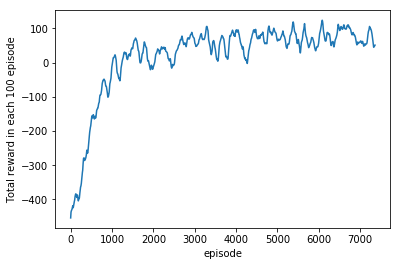

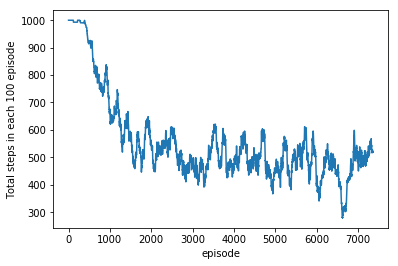

Wall time: 34min 32s


In [5]:
%%time
if __name__ == "__main__":
    
    # GPU settings and Init Graph
    tf.reset_default_graph()
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    SESS = tf.Session(config = config)

    # Environment
    ArmEnv = env.ArmEnv()
    
    # Global Network
    GLOBAL_AC = AC_Network("Global", ArmEnv.state_dim, ArmEnv.action_dim)
        
    # Local Network (workers)
    workers = []
    for i in range(multiprocessing.cpu_count()):
        name = "Worker_%d" % i 
        workers.append(Worker(name, GLOBAL_AC))

    COORD = tf.train.Coordinator()
    SESS.run(tf.global_variables_initializer())

    # Start
    worker_threads = []
    for worker in workers:
        job = lambda: worker.work()
        t = threading.Thread(target=job)
        t.start()
        worker_threads.append(t)
    COORD.join(worker_threads)

    # Rewards per 100 episodes
    episode_rewards100 = np.zeros(len(GLOBAL_RUNNING_REWARD) - 100)
    for i in range(len(GLOBAL_RUNNING_REWARD) - 100):
        for j in range(100):
            episode_rewards100[i] += GLOBAL_RUNNING_REWARD[i+j]
        episode_rewards100[i] /= 100
    plt.plot(episode_rewards100)
    plt.xlabel("episode")
    plt.ylabel("Total reward in each 100 episode")
    plt.show()
    
    # Steps per 100 episodes
    episode_steps100 = np.zeros(len(GLOBAL_RUNNING_STEPS) - 100)
    for i in range(len(GLOBAL_RUNNING_STEPS) - 100):
        for j in range(100):
            episode_steps100[i] += GLOBAL_RUNNING_STEPS[i+j]
        episode_steps100[i] /= 100
    plt.plot(episode_steps100)
    plt.xlabel("episode")
    plt.ylabel("Total steps in each 100 episode")
    plt.show()
    
    GLOBAL_AC.save_Network()

In [6]:
ArmEnv = env.ArmEnv()
state = ArmEnv.reset()
tf.reset_default_graph()
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
SESS = tf.Session(config = config)
Agent = AC_Network("Global", ArmEnv.state_dim, ArmEnv.action_dim, load_path = "./Network_save/A3C")

INFO:tensorflow:Restoring parameters from ./Network_save/A3C


In [7]:
i = 0
done = False
while(i < 3000):
    ArmEnv.render()
    action = Agent.choose_action(state)
    state, _, done = ArmEnv.step(action)
    if(done):
        i += 1
ArmEnv.close()

In [7]:
ArmEnv.close()